# Common Libraries

In [1]:
import os
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.6" # for linux

import pickle
import numpy as np
import cupy as cp
import nibabel as nb
from glob import glob
from tqdm import trange
from numba import cuda
cuda.select_device(0)

from rsatoolbox.util.searchlight import get_volume_searchlight
#from nltools.data import Brain_Data
from collections import Counter
from itertools import combinations

In [2]:
from boostrsa.boostrsa_types import ShrinkageMethod
from boostrsa.cores.gpu.basic_operations import outer_sum_square, outer_sum

In [3]:
import sys
sys.path.append("/home/seojin/boostrsa/src/boostrsa/cores/cpgpu")

from stats import _covariance_diag

In [4]:
import sys
sys.path.append("/home/seojin/boostrsa/src/boostrsa/cores/cpu")
from mask import set_mask

In [5]:
import sys
sys.path.append("/home/seojin/Seojin_commonTool/Module")

from memory_management import convert_byte

# Params

In [6]:
subj_name = "DO01"
is_update_data = False

# Searchlight
radius = 3
threshold = 1

# Task params
n_split_data = 2048
n_thread_per_block = 1024
shrinkage_method = ShrinkageMethod.shrinkage_diag
n_block = int(np.ceil(n_split_data / n_thread_per_block))

# Constants

In [7]:
data_dir_path = f"/mnt/ext3/hanul/DO/stats/beta/{subj_name}/green_time"
full_mask_path = f"/mnt/ext3/hanul/DO/fMRI_data/proc_data/{subj_name}/full_mask.DO01.nii"
temp_dir_path = "/mnt/ext1/seojin/temp/test"

In [8]:
beta_paths = sorted(glob(os.path.join(data_dir_path, f"{subj_name}_beta_all_r*.nii")))
condition_paths = sorted(glob(os.path.join(data_dir_path, f"{subj_name}_conditions_r*.npy")))
residual_paths = sorted(glob(os.path.join(data_dir_path, f"{subj_name}_residual_r*.nii")))

In [9]:
if is_update_data:
    mask = nb.load(full_mask_path)
    betas = [Brain_Data(path, mask = mask) for path in beta_paths]
    conditions = [np.load(path, allow_pickle=True) for path in condition_paths]
    residuals = [Brain_Data(path, mask = mask) for path in residual_paths]

    for i, beta in enumerate(betas):
        np.save(os.path.join(temp_dir_path, f"beta_r{i+1}.npy"), beta.data)
    
    for i, residual in enumerate(residuals):
        np.save(os.path.join(temp_dir_path, f"residual_r{i+1}.npy"), residual.data)
    
    for i, condition in enumerate(conditions):
        np.save(os.path.join(temp_dir_path, f"condition_r{i+1}.npy"), condition)
else:
    betas = [np.load(f"/mnt/ext1/seojin/temp/test/beta_r{i+1}.npy", allow_pickle = True) for i in range(0, 1)]
    conditions = [np.load(f"/mnt/ext1/seojin/temp/test/condition_r{i+1}.npy", allow_pickle = True) for i in range(0, 1)]
    residuals = [np.load(f"/mnt/ext1/seojin/temp/test/residual_r{i+1}.npy", allow_pickle = True) for i in range(0, 1)]

# Test - GPU masking

In [10]:
"""i = 0
n_channel = len(mask_1d_indexes)
n_block = int(np.ceil(n_split_data / n_thread_per_block))

target_neighbors_ = target_neighbors[i:i + n_split_data, :]
n_neighbor = target_neighbors.shape[1]

n_target_center = len(target_neighbors_)
mask_out = cuda.to_device(np.zeros((n_target_center, n_channel)))
set_mask[n_block, n_thread_per_block](target_neighbors_, mask_1d_indexes, mask_out)
memory_usage = memory(mask_out.nbytes, "GB")
print(f"{memory_usage}GB")"""

'i = 0\nn_channel = len(mask_1d_indexes)\nn_block = int(np.ceil(n_split_data / n_thread_per_block))\n\ntarget_neighbors_ = target_neighbors[i:i + n_split_data, :]\nn_neighbor = target_neighbors.shape[1]\n\nn_target_center = len(target_neighbors_)\nmask_out = cuda.to_device(np.zeros((n_target_center, n_channel)))\nset_mask[n_block, n_thread_per_block](target_neighbors_, mask_1d_indexes, mask_out)\nmemory_usage = memory(mask_out.nbytes, "GB")\nprint(f"{memory_usage}GB")'

# Data configuration

In [11]:
is_update_neighbors = False

In [12]:
# Mask
mask = nb.load(full_mask_path)
nx, ny, nz = mask.get_fdata().shape
mask_3d_indexes = np.array(np.where(mask.get_fdata() == 1))
mask_1d_indexes = np.ravel_multi_index(mask_3d_indexes, (nx, ny, nz))

# Neighbors
if is_update_neighbors:
    centers, neighbors = get_volume_searchlight(mask.get_fdata(), 
                                                radius=radius, 
                                                threshold=threshold)
    np.save(os.path.join(temp_dir_path, "centers.npy"), centers)
    with open(os.path.join(temp_dir_path, "neighbors"),"wb") as f:
        pickle.dump(neighbors, f)
else:
    centers = np.load(os.path.join(temp_dir_path, "centers.npy"))
    with open(os.path.join(temp_dir_path, "neighbors"),"rb") as f:
        neighbors = pickle.load(f)
    
n_neighbors = np.array([len(e) for e in neighbors])
uq_n_neighbors = np.unique([len(e) for e in neighbors])

flags = (n_neighbors == Counter(n_neighbors).most_common()[0][0])
centers = centers[flags]
neighbors = [e for e, f in zip(neighbors, flags) if f]
neighbors = np.array(neighbors)
n_neighbor = neighbors.shape[-1]

In [13]:
sim_run = 12

# Betas
beta = []
for i in range(1, sim_run):
    beta.append(betas[0])
beta = np.concatenate(beta)

# Condition
condition = []
for i in range(1, sim_run):
    condition.append(conditions[0])
condition = np.concatenate(condition)

# Residuals
residual = np.expand_dims(residuals[0], axis = 0)
for i in range(1, sim_run):
    residual = np.r_[residual, np.expand_dims(residuals[0], axis = 0)]

n_run, n_point, n_channel = residual.shape
n_cond = beta.shape[0]

# Sessions
sessions = np.concatenate([np.repeat(run_number, condition.shape[0] / n_run) for run_number in range(1, n_run + 1)])
uq_sessions = np.unique(sessions)

In [14]:
dtype = np.float32

In [15]:
residual = residual.astype(dtype)
beta = beta.astype(dtype)

In [16]:
fold_info = list(combinations(np.arange(len(uq_sessions)), 2))
n_fold = len(fold_info)

# Split mask

In [17]:
target_centers = centers[:n_split_data]
target_neighbors = neighbors[:n_split_data]
split_mask = set_mask(target_neighbors, mask_1d_indexes)

# Masked

In [18]:
masked_measurements = np.empty((n_split_data, n_cond, n_neighbor), dtype = beta.dtype)
for j, m in enumerate(split_mask):
    masked_measurements[j] = beta[:, m == 1]
masked_measurements = cp.asarray(masked_measurements)

In [19]:
masked_residuals = np.empty((n_split_data, n_run, n_point, n_neighbor),
                            dtype=residual.dtype)
for i, m in enumerate(split_mask):
    masked_residuals[i] = residual[:, :, m == 1]

# Preprocessing

In [54]:
# Calculate demean
target_residuals = masked_residuals.reshape(-1, n_point, n_neighbor)
mean_residuals = np.mean(target_residuals, axis = 1, keepdims=1)
target_residuals = (target_residuals - mean_residuals)

# Covariance

In [55]:
n_processing_unit = target_residuals.shape[0]

In [57]:
out_sum_device = cuda.to_device(np.zeros((n_processing_unit, n_neighbor, n_neighbor), dtype = dtype))
print(convert_byte(out_sum_device.nbytes, "GB"), "GB")

outer_sum[n_block, n_thread_per_block](target_residuals, out_sum_device)
outer_sum_result = out_sum_device.copy_to_host()
del out_sum_device

0.3959197998046875 GB


/home/seojin/anaconda3/envs/boostrsa/lib/python3.9/site-packages/numba/cuda/dispatcher.py:538: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/boostrsa/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [87]:
out_sum_square_device = cuda.to_device(np.zeros((n_processing_unit, n_neighbor, n_neighbor), dtype = dtype))
print(convert_byte(out_sum_square_device.nbytes, "GB"), "GB")

outer_sum_square[n_block, n_thread_per_block](target_residuals, out_sum_square_device)
outer_sum_square_result = out_sum_square_device.copy_to_host()
del out_sum_square_device

0.791839599609375 GB


/home/seojin/anaconda3/envs/boostrsa/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [27]:
s = outer_sum_result / n_point
s2 = outer_sum_square_result / n_point
b2 = np.sum(s2 - s * s, axis = (1, 2)) / n_point

In [28]:
repeat_eyes = np.repeat(np.eye(n_neighbor)[:, :, np.newaxis], n_processing_unit, axis = 2).T

In [29]:
diag_s = np.diagonal(s, axis1 = 1, axis2 = 2)
m = (np.sum(diag_s, axis = 1) / n_neighbor)
d2 = np.sum((s - m[:, None, None] * repeat_eyes) ** 2, axis = (1, 2))

In [30]:
b2 = np.minimum(d2, b2)

In [31]:
s_shrink = (b2 / d2 * m)[:, None, None] * repeat_eyes + ((d2-b2) / d2)[:, None, None] * s

/tmp/ipykernel_2353319/1731073590.py:1: RuntimeWarning: invalid value encountered in divide
  s_shrink = (b2 / d2 * m)[:, None, None] * repeat_eyes + ((d2-b2) / d2)[:, None, None] * s


In [32]:
dof = n_point - 1
s_shrink = s_shrink * n_point / dof

In [34]:
precisions = cp.linalg.inv(cp.asarray(s_shrink)).get()

In [35]:
r, c = np.triu_indices(n_neighbor, k = 0)

In [39]:
precisions = precisions[ :, r, c]

In [40]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [90]:
np.save(os.path.join(temp_dir_path, "precision.npy"), precisions)

# Fold precision

In [19]:
dtype = np.float32

In [20]:
precisions = np.load(os.path.join(temp_dir_path, "precision.npy"))
precisions = precisions.astype(dtype)

In [21]:
from boostrsa.cores.cpu.matrix import convert_1d_to_symmertic, mean_fold_variance

In [22]:
prec_mat_shape = int((n_neighbor * n_neighbor - n_neighbor) / 2) + n_neighbor
target_precs = precisions.reshape(-1, prec_mat_shape)
target_precs = np.array([convert_1d_to_symmertic(pre, size = n_neighbor).astype(dtype) for pre in target_precs])
variances = cp.linalg.inv(cp.asarray(target_precs))

In [23]:
variances = variances.reshape(len(target_centers), n_run, n_neighbor, n_neighbor).get()

In [24]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [83]:
fold_preicions = cp.linalg.inv(cp.asarray(mean_fold_variance(variances, fold_info)))
fold_preicions = fold_preicions.get()

In [84]:
mempool.free_all_blocks()

In [85]:
fold_preicions = fold_preicions.reshape(len(target_centers), len(fold_info), n_neighbor, n_neighbor)

In [ ]:
r, c = np.triu_indices(n_neighbor, k = 0)
fold_preicions = fold_preicions[:, :, r, c]

In [27]:
fold_preicions = cuda.to_device(fold_preicions)

In [82]:
convert_byte(a.nbytes, "GB")

2.2009735107421875

In [50]:
fold_preicions.nbytes

4676272128

In [28]:
a = fold_preicions.copy_to_host()

In [29]:
a.shape

(2048, 66, 93, 93)

In [38]:
from seaborn import heatmap

In [45]:
a[0,0][1, :]

array([-3.64292692e-03,  9.96928290e-02, -3.75739834e-03, -2.07723095e-03,
       -2.64275214e-03, -3.14432615e-03, -2.04832107e-03, -1.01539236e-03,
       -1.82595022e-03, -1.89706974e-03, -1.09616085e-03, -1.32858183e-03,
       -1.65057764e-03, -2.56326492e-03, -2.10198923e-03, -1.42936397e-03,
       -2.66808108e-03, -2.81260279e-03, -1.93268189e-03, -9.03815380e-04,
       -6.45148568e-04, -2.05235765e-03, -2.05995119e-03, -8.97174235e-04,
        1.82054391e-05, -6.81748963e-04, -1.69409241e-03, -1.47662230e-03,
       -6.39508653e-04, -3.93613911e-04, -1.28163700e-03, -1.46438205e-03,
       -1.27443764e-03, -1.42347405e-03, -1.72166759e-03, -1.64049759e-03,
       -1.39335508e-03, -1.03869464e-03, -7.72107625e-04, -1.69957604e-03,
       -1.66335073e-03, -1.20497716e-03, -6.42547035e-04, -5.27825905e-04,
       -1.56156626e-03, -1.39109057e-03, -5.35389932e-04,  1.68155777e-04,
       -3.93828930e-04, -1.56051316e-03, -1.24565512e-03, -3.48843430e-04,
        1.77065143e-04, -

In [46]:
a[0,0][:, 1]

array([-3.64386500e-03,  9.96928290e-02, -3.75195639e-03, -2.07563001e-03,
       -2.64451280e-03, -3.14694573e-03, -2.05078581e-03, -1.01414078e-03,
       -1.82963931e-03, -1.89678068e-03, -1.09606166e-03, -1.32882025e-03,
       -1.65127264e-03, -2.56133452e-03, -2.09690304e-03, -1.43224502e-03,
       -2.66427826e-03, -2.81263632e-03, -1.93393661e-03, -8.99482635e-04,
       -6.42017345e-04, -2.05225986e-03, -2.05986807e-03, -8.95392557e-04,
        1.64444882e-05, -6.81497913e-04, -1.69557275e-03, -1.47623208e-03,
       -6.41560124e-04, -3.99976707e-04, -1.28155982e-03, -1.46380533e-03,
       -1.27098220e-03, -1.42428500e-03, -1.72182871e-03, -1.64501520e-03,
       -1.39086694e-03, -1.03831815e-03, -7.65649544e-04, -1.69971609e-03,
       -1.66761270e-03, -1.20711350e-03, -6.45318418e-04, -5.29807585e-04,
       -1.56125100e-03, -1.39469502e-03, -5.37822198e-04,  1.65521051e-04,
       -3.95857845e-04, -1.56401866e-03, -1.24200049e-03, -3.47508379e-04,
        1.76958551e-04, -

<Axes: >

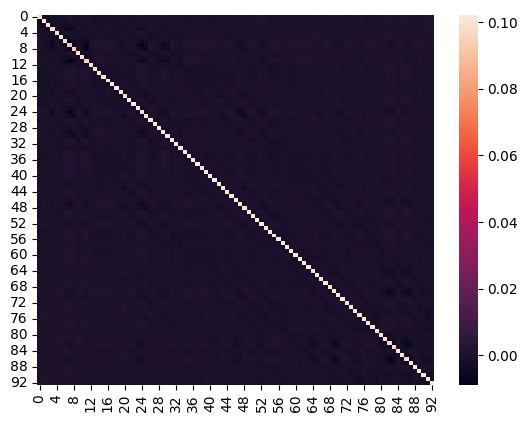

In [40]:
heatmap(a[0,0])

# AVG measurement per session

In [31]:
# Avg conds per session
avg_measurements = []
avg_conds = []
for session in uq_sessions:
    filtering_session = sessions == session
    sess_cond = condition[filtering_session]
    sess_measurements = cp.compress(filtering_session, masked_measurements, axis = 1)
    
    mean_measurments = []
    for cond in np.unique(condition):
        filtering_cond = (sess_cond == cond)
        cond_measurments = cp.compress(filtering_cond, sess_measurements, axis = 1)
        mean_cond_measurement = cp.mean(cond_measurments, axis = 1)
        mean_measurments.append(cp.expand_dims(mean_cond_measurement, axis = 1))

        avg_conds.append(cond)

    avg_measurements.append(cp.expand_dims(cp.concatenate(mean_measurments, axis = 1), axis = 1))
avg_measurements = cp.concatenate(avg_measurements, axis = 1).get()

avg_conds = np.array(avg_conds)

mempool.free_all_blocks()

In [42]:
convert_byte(2048 * 66 * 396 * 93 * 32, "GB")

148.35498046875

In [34]:
a = np.zeros((len(target_centers), n_fold, n_cond, n_neighbor), dtype = dtype)

In [51]:
a.nbytes

19911868416

In [52]:
convert_byte(a.nbytes, "GB")

18.54437255859375

In [50]:
# make kernel
avg_measurements = cuda.to_device(avg_measurements)

matmul1_out = cuda.to_device(np.zeros((len(target_centers), n_fold, n_cond, n_neighbor), dtype = dtype))
kernel_out = cuda.to_device(np.zeros((len(target_centers), n_fold, n_cond, n_cond), dtype = dtype))
calc_kernel[block_2ds, thread_2ds](avg_measurements, fold_preicions, fold_info, matmul1_out, kernel_out)

CudaAPIError: [2] Call to cuMemAlloc results in CUDA_ERROR_OUT_OF_MEMORY

In [51]:
del matmul1_out

In [45]:
len(target_centers), n_fold, n_cond, n_neighbor

(2048, 66, 396, 93)

18.54437255859375